# Assignment : Dimensionality Reduction using T-SNE on Amazon Fine Foods Review Dataset

T-SNE is a Dimensionality Reduction technique which converts the high dimension data to 2-D data so that we as humans can visualize it and understand patterns in the data. 

T-SNE Algorith takes only dense matrices as input. However, both BoW and TF-IDF output is in sparse form. So before feeding the vectorized data to T-SNE we convert it to dense using TruncatedSVD.

The objective of the assignment is to apply T-SNE on Amazon Fine Foods Reviews after converting the text into vectors using the following vectorization Techniques -  
1. Bag of Words
2. TF- IDF
3. Average Word2Vec
4. TF-IDF Weighted Word2Vec

After generating the the plots using T-SNE we can visualize the patterns in between positive and negative review text and decide if we can separate the points using some plane/hyperplane.


T-SNE is plotted using perplexity in the range of [2,20,30,50,80,100] with Iteration  = 1000

### 1. Importing Data

In [1]:
# Importing the required packages
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import gensim
import re
import string
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from tqdm import tqdm

In [2]:
# Making a connection to the sqllite file containing the reviews and then importing them into a dataframe
con = sqlite3.connect('AmazonReviews.sqlite')
review_dataset = pd.read_sql_query("""select * from reviews where score != '3'""",con)

In [3]:
# This function partitions the dataframe and deletes any neutral reviews(=3) 
#and marks all reviews above 3 as positive and below 3 as negative
def partition(data):
    if (data < 3):
        return 'negative'
    else:
        return 'positive'

    
review_score = review_dataset['Score']
positiveNegative = review_score.map(partition)
review_dataset['Score'] = positiveNegative

In [4]:
print(review_dataset.shape)
review_dataset.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### 2. PreProcessing Data

In [5]:
# Removing all duplicate reviews given by the same user on the same product at the same time
sorted_data=review_dataset.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)


#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(review_dataset['Id'].size*1.0)*100


(364173, 10)


69.25890143662969

In [6]:
# Removing entries where Numerator value > Denominator Value(Logically incorrect)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

(364171, 10)


In [7]:
# Considering 2500 +ve and 2500 -ve points from the main dataframe
final = final.sort_values('Score', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_positive = final.iloc[-2500:,]
final_negative = final.iloc[:2500:,]
print(final_positive.shape)
print(final_negative.shape)

(2500, 10)
(2500, 10)


In [8]:
# appending points from both classes and resetting the indices
final = final_positive.append(final_negative,ignore_index= True)
final = final.sample(frac=1).reset_index(drop=True)
print(final.head(5))
print(final.tail(5))

       Id   ProductId          UserId                         ProfileName  \
0  237125  B000XR5MLW   A3CCHD6Q7NTFK  Lydia A. Nyburg "voracious reader"   
1  165430  B000XB49U8  A1ZW047E768C10                             A. Cole   
2  436515  B000FFLTD2  A1DVIW06QACDQI                         M. E. Kelly   
3   80337  B000WZPX1E   ASF7RR940BKXE                         Elaine Dodd   
4   73594  B002C6IM2S  A1CPNV49GYJUEA                               jolie   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     3                       3  positive  1196380800   
1                     0                       0  positive  1343779200   
2                     0                       2  negative  1283385600   
3                     2                       2  positive  1206748800   
4                     0                       2  negative  1336694400   

                                     Summary  \
0      The yummiest chocolate bar ever made.   
1 

In [9]:
# Data Sampling if required
#final = final.iloc[:5000,:]

In [10]:
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

negative    2500
positive    2500
Name: Score, dtype: int64

### 4. Cleaning Data using techniques like Stop Words Removal, Stemming, removal of special characters and HTML Tags

In [11]:
#nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

In [12]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|██████████| 5000/5000 [00:05<00:00, 839.69it/s]


In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

### 5. T-SNE

In [15]:
# Function to plot T-SNE
def tsne(data,components,perplexity,iterations):
    tic = time.time()
    model = TSNE(n_components= components,random_state=0,perplexity= perplexity,n_iter= iterations)
    tsne_data = model.fit_transform(data)
    toc = time.time()
    #print("TSNE Function executed in: ",toc - tic,' seconds')
    return tsne_data

In [16]:
# PLot the T-SNE output using Seaborn
'''  Function to plot TSNE Model
     Arguments - 
     1. Data - Data on which TSNE will run
     2. Labels - Class Labels
     3. Perplexity = No of Datapoints whose distances should be preserved
     4. Iterations - No of times to iterate to reach optimal output
     ('Label')
 '''

def plotTSNE(data,labels,perplexity,iterations):
    tsne_df = pd.DataFrame(tsne_data,columns = ('Dim1','Dim2','Label'))
    #plt.title('With perplexity = ',perplexity)
    sns.FacetGrid(tsne_df,hue = ('Label'),height = 6, hue_order=["positive", "negative"]).map(plt.scatter,'Dim1','Dim2').add_legend()
    plt.plot()

### 6. Vectorization Techniques

#### A. Bag of Words

In [17]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 9485)
the number of unique words  9485


In [18]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'food', 2163), (b'dog', 1509), (b'tea', 1275), (b'like', 1051), (b'love', 1049), (b'cat', 892), (b'good', 856), (b'one', 814), (b'product', 777), (b'great', 747), (b'tast', 714), (b'tri', 703), (b'use', 687), (b'get', 661), (b'eat', 627), (b'bag', 572), (b'make', 531), (b'flavor', 530), (b'time', 485), (b'much', 482)]
Most Common Negative Words :  [(b'tast', 1652), (b'like', 1568), (b'product', 1302), (b'flavor', 1062), (b'one', 901), (b'tri', 835), (b'food', 817), (b'would', 803), (b'good', 704), (b'tea', 690), (b'get', 597), (b'eat', 591), (b'use', 585), (b'order', 577), (b'buy', 576), (b'box', 545), (b'dont', 500), (b'even', 500), (b'amazon', 475), (b'realli', 462)]


In [19]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 141298)
the number of unique words including both unigrams and bigrams  141298


In [36]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(final_counts)
print("BOW UniGram Shape: ",standardized_data.shape)
#standardized_data.toarray()

# Standardize Data
standardized_data_bigram = StandardScaler( with_mean=False).fit_transform(final_bigram_counts)
print("BOW BiGram Shape: ",standardized_data_bigram.shape)
#standardized_data.toarray()


BOW UniGram Shape:  (5000, 9485)
BOW BiGram Shape:  (5000, 141298)


#### Converting the sparse matrices into dense as T-SNE takes only dense matrices as input 

In [21]:

#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 2000,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)

standardized_data_bigram = truncated.fit_transform(standardized_data_bigram)
print(standardized_data_bigram.shape)



(5000, 2000)
(5000, 2000)


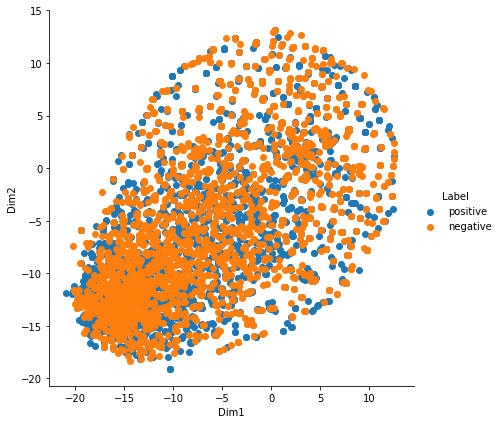

TSNE on BOW Unigram with perplexity =  2 and iterations = 1000


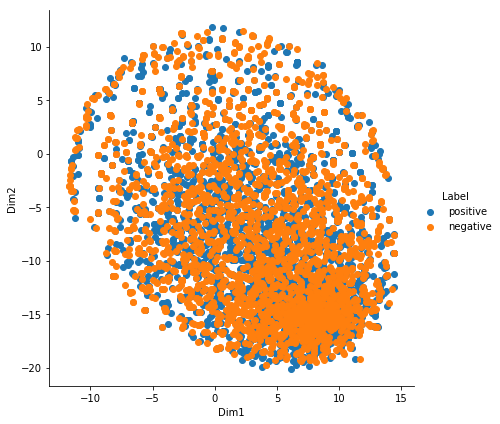

TSNE on BOW Unigram with perplexity =  20 and iterations = 1000


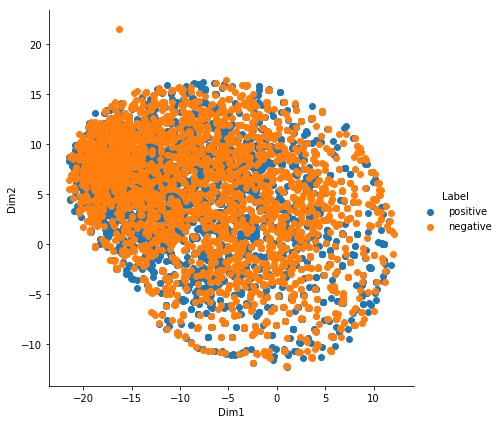

TSNE on BOW Unigram with perplexity =  30 and iterations = 1000


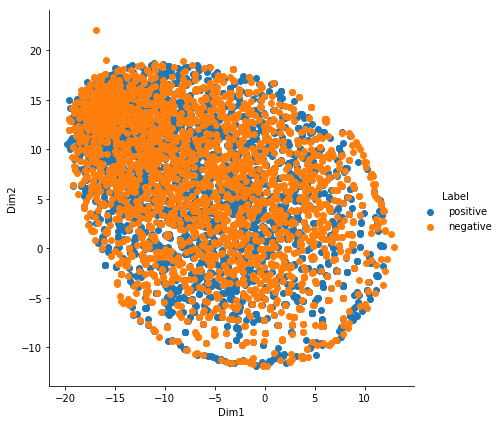

TSNE on BOW Unigram with perplexity =  50 and iterations = 1000


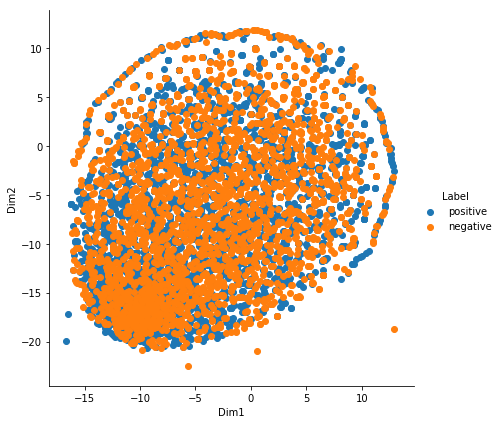

TSNE on BOW Unigram with perplexity =  80 and iterations = 1000


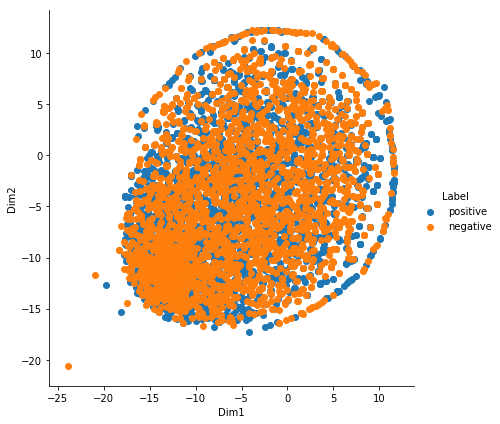

TSNE on BOW Unigram with perplexity =  100 and iterations = 1000


In [22]:
# Feeding the output of UniGRam BoW to T-SNE

test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity = [2,20,30,50,80,100]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE on BOW Unigram with perplexity = ',i,'and iterations = 1000') 

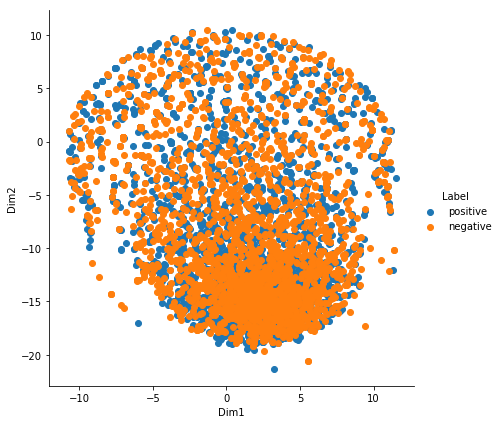

TSNE on BOW Bigram  with perplexity =  2 and iterations = 1000


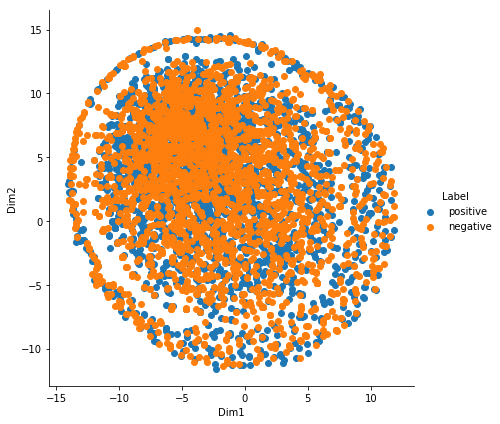

TSNE on BOW Bigram  with perplexity =  20 and iterations = 1000


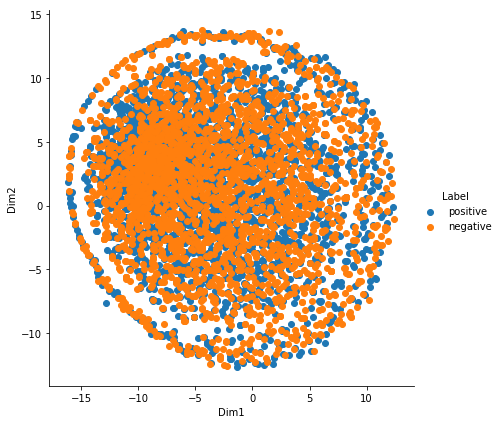

TSNE on BOW Bigram  with perplexity =  30 and iterations = 1000


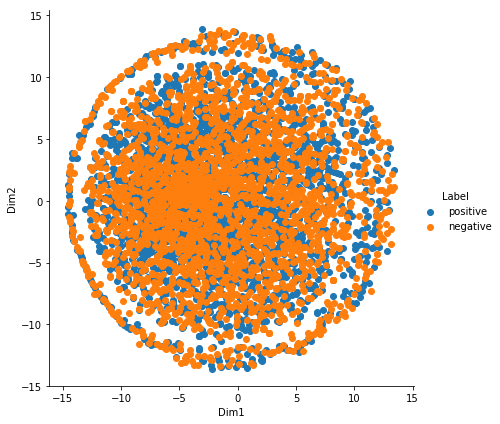

TSNE on BOW Bigram  with perplexity =  50 and iterations = 1000


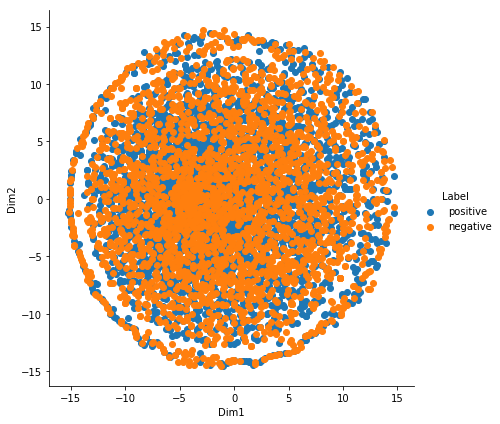

TSNE on BOW Bigram  with perplexity =  80 and iterations = 1000


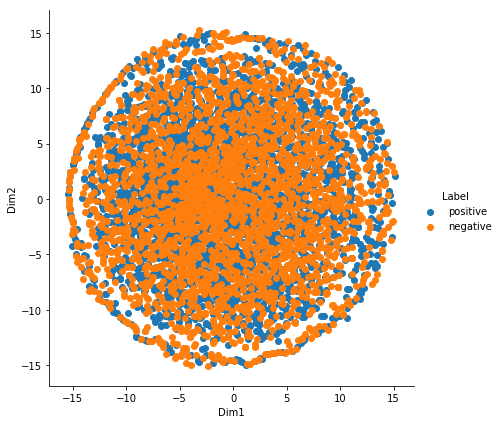

TSNE on BOW Bigram  with perplexity =  100 and iterations = 1000


In [23]:
# Feeding the output of BiGram BoW to T-SNE

test_data= standardized_data_bigram
test_label = final['Score']
#test_label = test_label[:100,]



perplexity = [2,20,30,50,80,100]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE on BOW Bigram  with perplexity = ',i,'and iterations = 1000') 

#### B. TFIDF

In [24]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 141298)
the number of unique words including both unigrams and bigrams  141298


In [25]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(final_tf_idf)
print(standardized_data.shape)
#standardized_data.toarray()
#standardized_data = standardized_data[:100,]

(5000, 141298)


#### Converting the sparse matrices into dense as T-SNE takes only dense matrices as input 

In [26]:

#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 2000,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)

(5000, 2000)


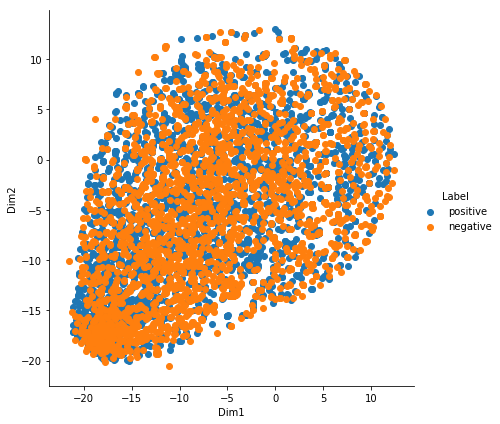

TSNE on TFIDF with perplexity =  2 and iterations = 1000


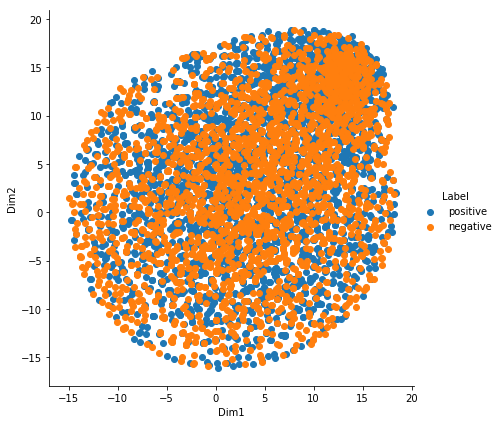

TSNE on TFIDF with perplexity =  20 and iterations = 1000


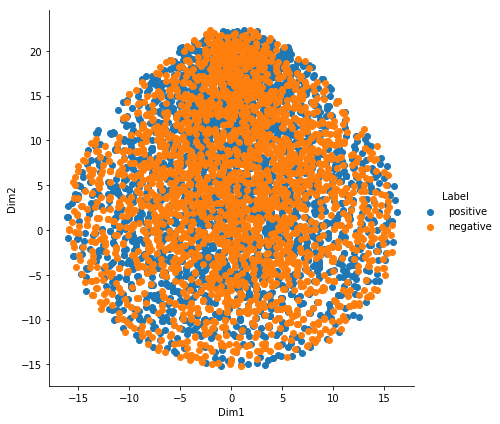

TSNE on TFIDF with perplexity =  30 and iterations = 1000


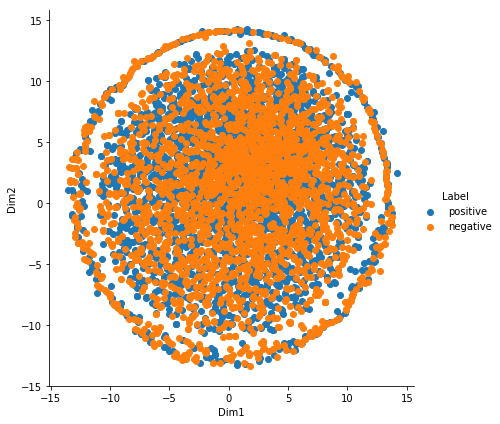

TSNE on TFIDF with perplexity =  50 and iterations = 1000


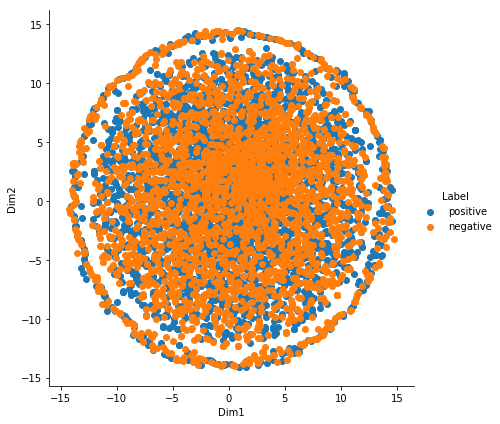

TSNE on TFIDF with perplexity =  80 and iterations = 1000


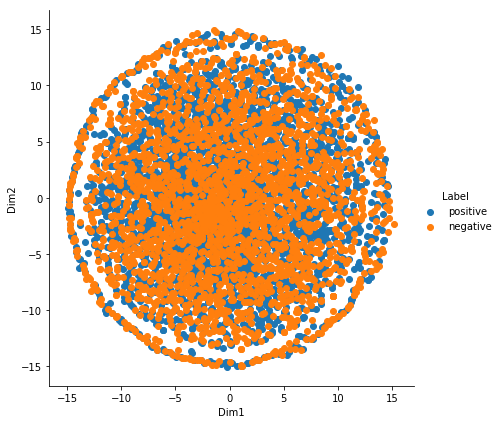

TSNE on TFIDF with perplexity =  100 and iterations = 1000


In [27]:
# Feeding the output of TF-IDF to T-SNE

test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity = [2,20,30,50,80,100]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE on TFIDF with perplexity = ',i,'and iterations = 1000') 

#### C. Average Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [29]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [30]:
w2v_words = list(w2v_model.wv.vocab)

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:08<00:00, 574.39it/s]

5000
50


(5000, 50)


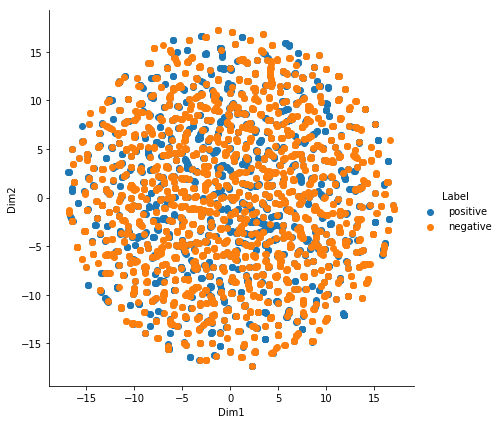

TSNE on Average Word2Vec with perplexity =  2 and iterations = 1000


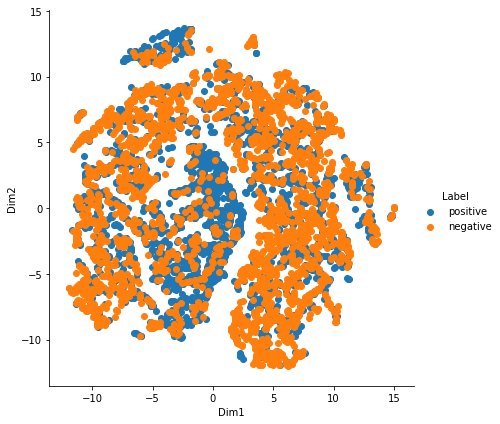

TSNE on Average Word2Vec with perplexity =  20 and iterations = 1000


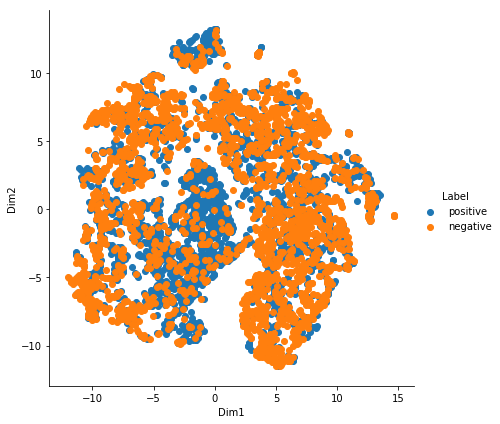

TSNE on Average Word2Vec with perplexity =  30 and iterations = 1000


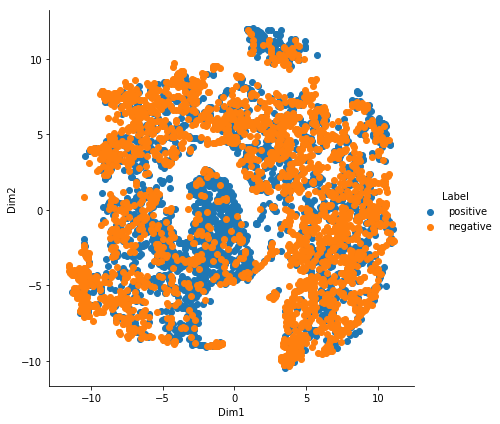

TSNE on Average Word2Vec with perplexity =  50 and iterations = 1000


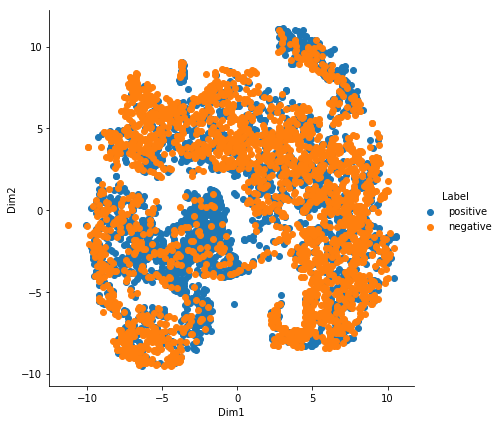

TSNE on Average Word2Vec with perplexity =  80 and iterations = 1000


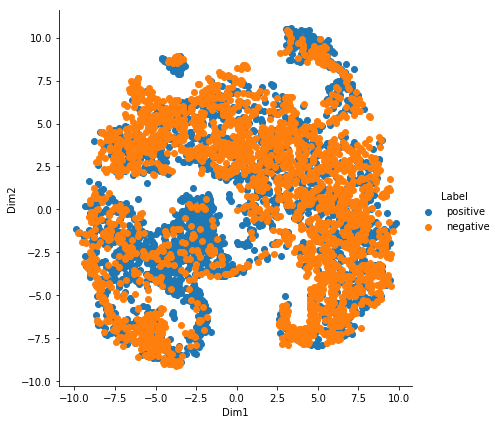

TSNE on Average Word2Vec with perplexity =  100 and iterations = 1000


In [32]:
# Feeding the output of Average Word2Vec to T-SNE

# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(sent_vectors)
print(standardized_data.shape)
#standardized_data.toarray()
#standardized_data = standardized_data[:100,]


test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity =  [2,20,30,50,80,100]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE on Average Word2Vec with perplexity = ',i,'and iterations = 1000') 

#### D. TF-IDF Weighted Word2Vec

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names()

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_feat, list(tf_idf_vect.idf_)))
#print(tfidf_feat)
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf


tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(final['CleanedText'].values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:04<00:00, 1247.43it/s]


(5000, 50)


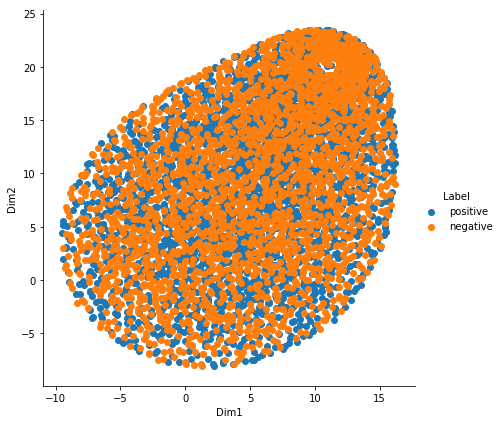

TSNE on TFIDF Weighted Word2Vec with perplexity =  2 and iterations = 1000


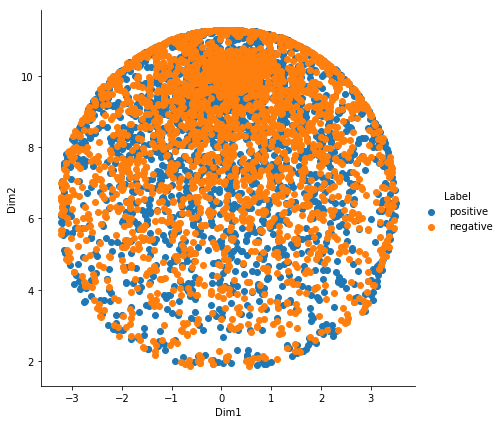

TSNE on TFIDF Weighted Word2Vec with perplexity =  20 and iterations = 1000


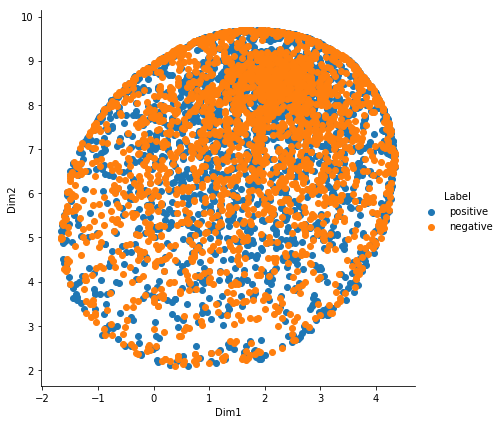

TSNE on TFIDF Weighted Word2Vec with perplexity =  30 and iterations = 1000


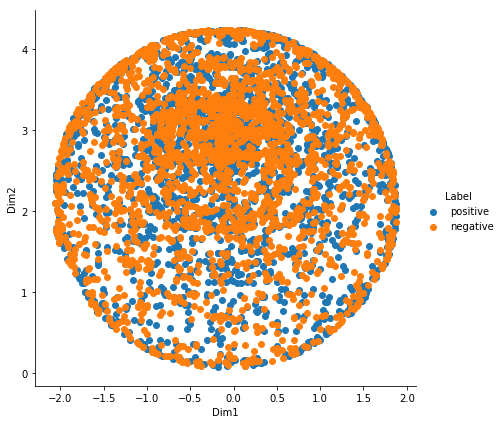

TSNE on TFIDF Weighted Word2Vec with perplexity =  50 and iterations = 1000


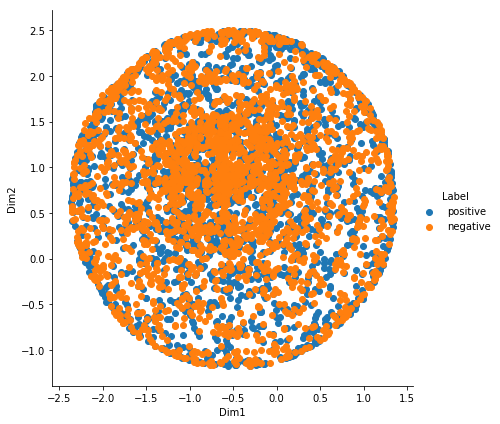

TSNE on TFIDF Weighted Word2Vec with perplexity =  80 and iterations = 1000


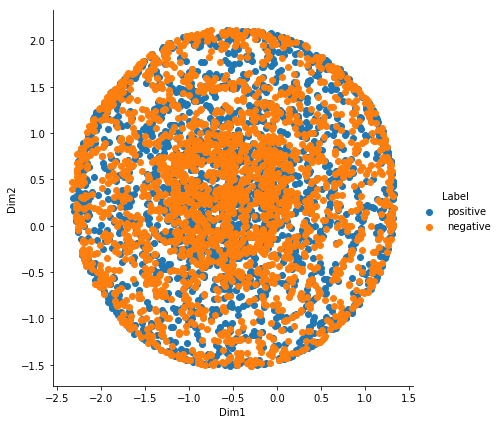

TSNE on TFIDF Weighted Word2Vec with perplexity =  100 and iterations = 1000


In [34]:
# Feeding the output of TF-IDF Weighted Word2Vec to T-SNE

# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)




test_data= standardized_data
test_label = final['Score']




perplexity =  [2,20,30,50,80,100]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE on TFIDF Weighted Word2Vec with perplexity = ',i,'and iterations = 1000') 

### 7. Conclusion

The Ouput of T-SNE using the 4 vectorization techniques are described below - 
1. BoW - There is no visible structure in the plot and all of the points seems to overlap of each other
2. TF-IDF - There is no visible structure in the plot and all of the points seems to overlap of each other
3. Average Word2Vec - **For higher perplexity values, the plot seems to show some structure. However, points from both classes seems to overlap**
4. TF-IDF Weighted Word2Vec - There is no visible structure in the plot and all of the points seems to overlap of each other